In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
from src.multi_model_large_ensemble import MultiModelLargeEnsemble
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [45]:
import dask
def convert_longitude_360to180(ds):
    """Convert ds from 0 to 360 longitude to -180 to 180 coordinate

    Parameters
    ----------
    ds: xr.Dataset
        CMIP model dataset

    Returns
    -------
    ds: xr.Dataset
        Same CMIP dataset with converted longitude
    """
    ds = ds.assign_coords({'lon': ds.lon.where(ds.lon <= 180, ds.lon - 360)})
    # To silence large chunk warning
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = ds.sortby(ds.lon)
    return ds

In [3]:
import matplotlib.pyplot as plt
plt.style.use('default')

In [16]:
from src.post_p_large_ensemble import run_seasonal_qdm, qdm_large_ensemble

In [158]:
era2cmip = {
    't2m': 'tas',
    't2m_max': 'tasmax',
    't2m_min': 'tasmin',
    'tp': 'pr',
    'huss': 'huss',  # Specific humidity does not exist in ERA, so just mapping CMIP to CMIP
    # 'd2m': 'tdps',
    'ws': 'sfcWind',
    'sm': 'mrsos'  # https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2020GL089991
}

cmip2era = {v: k for k, v in era2cmip.items()}

regions_dict = {
    'USeast': {'lat': 41.3, 'lon': -72.5},
    'USwest':  {'lat': 37.7, 'lon': -122.4, },
    'iceland':  {'lat': 65, 'lon': -19},
    'europe':  {'lat': 51, 'lon': 10.5},
    'australia': {'lat': -25.2, 'lon': 133.7},
    'tropics': {'lat': 3.9, 'lon': -53.1}
}

variable = 'pr'

models_for_vars = {
    'tas': ['CanESM5', 'cesm_lens', 'MIROC6', 'MPI-ESM1-2-LR', 'EC-Earth3'],
    'pr': ['CanESM5', 'cesm_lens', 'MIROC6', 'MPI-ESM1-2-LR'],
    'tasmax': ['CanESM5', 'cesm_lens', 'MIROC6', 'MPI-ESM1-2-LR', 'EC-Earth3'],
}
# ,['USwest', 'europe', 'australia', 'tropics', 'USeast', 'iceland']:
region  ='australia'
lat = regions_dict[region]['lat']
lon = regions_dict[region]['lon']
print(f'Processing {region} future for {variable}')


path = f'gcs://climateai_data_repository/tmp/internal_variability/era_files/{region}/reanalysis_daily.zarr'
reanalysis_daily = xr.open_zarr(path, consolidated=True).load()

if variable in ('tasmax', 'tas'):
    reanalysis_daily[cmip2era[variable]] += 273.15
elif variable in ('pr'):
    reanalysis_daily[cmip2era[variable]] *= (997/(1000*24*60*60))


Processing australia future for pr


In [114]:
australia_tas = MultiModelLargeEnsemble(models=models, variable='tasmax', granularity='day', 
                               lat=-25.2, lon=133.7, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [102]:
tropics_tas = MultiModelLargeEnsemble(models=models, variable='tas', granularity='day', 
                               lat=3.9, lon=306.9, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [55]:
import sys
sys.path.append('/home/jupyter/AdaptationAnalysis')
from app.main.src.climate_projection import ClimateProjection


In [15]:
models = ['MIROC6', 'CanESM5', 'MPI-ESM1-2-LR', 'EC-Earth3','cesm_lens']

In [90]:
europe = MultiModelLargeEnsemble(models=models, variable='tasmax', granularity='day', 
                               lat=51, lon=10.5, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [116]:
tropics_pr = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=3.9, lon=306.9, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [44]:
(obs.lat.values, tro.lon.values)

(array(4., dtype=float32), array(-53., dtype=float32))

In [238]:
obs =  reanalysis_daily[cmip2era[variable]]

large_ens_hist = qdm_large_ensemble(
    australia_pr.hist_dsets,
    tropics_pr.hist_dsets,
    obs.load(),
    monthly_w = 3,
)

CanESM5 has been post-processed
EC-Earth3 has been post-processed
MIROC6 has been post-processed
MPI-ESM1-2-LR has been post-processed
cesm_lens has been post-processed


In [239]:
obs =  reanalysis_daily[cmip2era[variable]]

large_ens_future = qdm_large_ensemble(
    australia_pr.future_dsets,
    australia_pr.hist_dsets,
    obs.load(),
    monthly_w = 3,
)

CanESM5 has been post-processed
EC-Earth3 has been post-processed
MIROC6 has been post-processed
MPI-ESM1-2-LR has been post-processed
cesm_lens has been post-processed


In [186]:
list(tropics.hist_dsets.keys())

['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR', 'EC-Earth3']

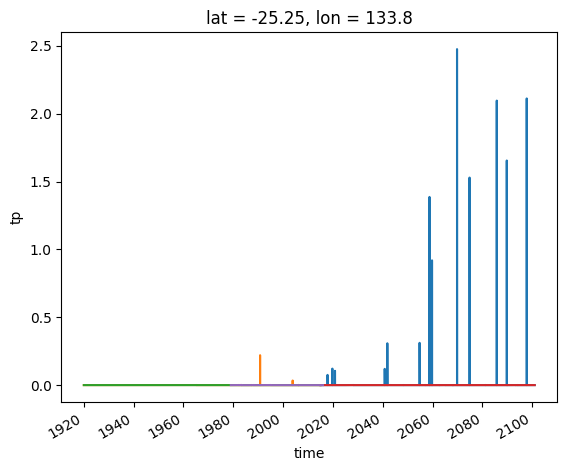

In [193]:
model = 'MPI-ESM1-2-LR'
large_ens_future[model].sel(member_id=1).plot()
large_ens_hist[model].sel(member_id=1).plot()
australia_pr.hist_dsets[model].sel(member_id=1).plot()

australia_pr.future_dsets[model].sel(member_id=1).plot()
obs.sel(time=slice('1970', '2015')).plot()

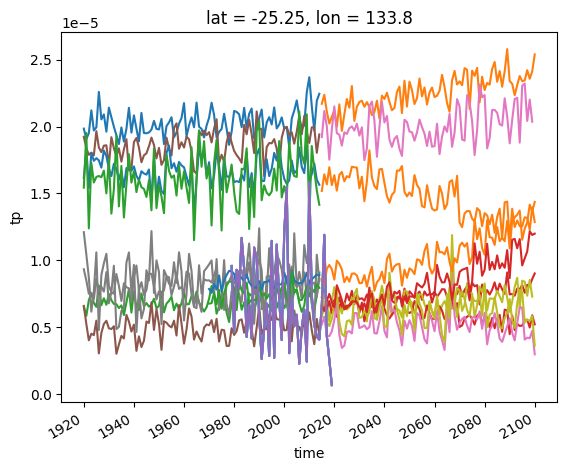

In [240]:
for model in list(tropics.hist_dsets.keys()):

    australia_pr.hist_dsets[model].resample(time='AS').mean().mean('member_id').plot()
    australia_pr.future_dsets[model].resample(time='AS').mean().mean('member_id').plot()

    (large_ens_hist[model]).resample(time='AS').mean().mean('member_id').plot()
    (large_ens_future[model]).resample(time='AS').mean().mean('member_id').plot()

    (obs).resample(time='AS').mean().plot()

In [241]:
australia_pr = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=-25.2, lon=133.7, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [242]:
australia_pr_qdm = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=-25.2, lon=133.7, 
                               bucket='climateai_data_repository', path='tmp/qdm_australia')

In [243]:
tropics_pr_qdm = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=3.9, lon=306.9, 
                               bucket='climateai_data_repository', path='tmp/qdm_tropics')

In [244]:
tropics_pr = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=3.9, lon=306.9, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [251]:
europe_pr = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=51, lon=10.5, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [252]:
europe_pr_qdm = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=51, lon=10.5, 
                               bucket='climateai_data_repository', path='tmp/qdm_europe')

In [253]:
for model in list(tropics.hist_dsets.keys()):

    europe_pr.hist_dsets[model].load()
    europe_pr.future_dsets[model].load()

    (europe_pr_qdm.hist_dsets[model]).load()
    (europe_pr_qdm.future_dsets[model]).load()

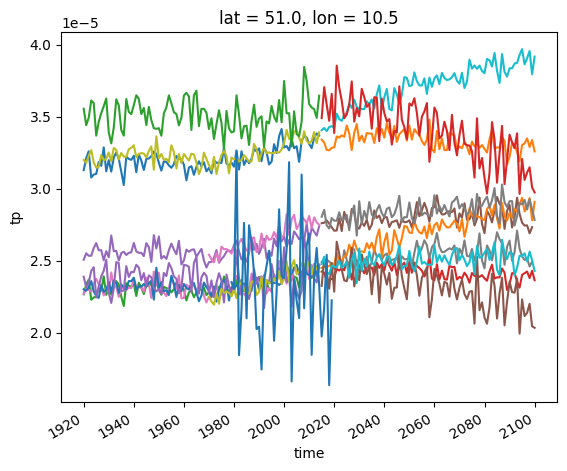

In [259]:
for model in list(tropics.hist_dsets.keys()):

    europe_pr.hist_dsets[model].resample(time='AS').mean().mean('member_id').plot()
    europe_pr.future_dsets[model].resample(time='AS').mean().mean('member_id').plot()

    (europe_pr_qdm.hist_dsets[model]).resample(time='AS').mean().mean('member_id').plot()
    (europe_pr_qdm.future_dsets[model]).resample(time='AS').mean().mean('member_id').plot()

path = f'gcs://climateai_data_repository/tmp/internal_variability/era_files/europe/reanalysis_daily.zarr'
reanalysis_daily = xr.open_zarr(path, consolidated=True).load()
(reanalysis_daily[cmip2era[variable]]* (997/(1000*24*60*60))).resample(time='AS').mean().plot()

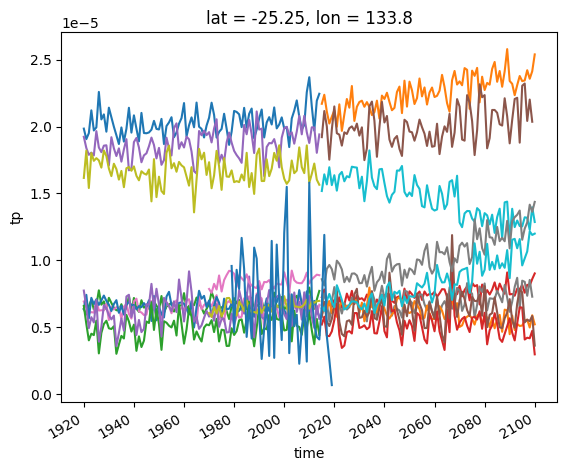

In [258]:
for model in list(tropics.hist_dsets.keys()):

    australia_pr.hist_dsets[model].resample(time='AS').mean().mean('member_id').plot()
    australia_pr.future_dsets[model].resample(time='AS').mean().mean('member_id').plot()

    (australia_pr_qdm.hist_dsets[model]).resample(time='AS').mean().mean('member_id').plot()
    (australia_pr_qdm.future_dsets[model]).resample(time='AS').mean().mean('member_id').plot()

path = f'gcs://climateai_data_repository/tmp/internal_variability/era_files/australia/reanalysis_daily.zarr'
reanalysis_daily = xr.open_zarr(path, consolidated=True).load()
(reanalysis_daily[cmip2era[variable]]* (997/(1000*24*60*60))).resample(time='AS').mean().plot()

In [ ]:
for model in list(tropics.hist_dsets.keys()):

    australia_tas.hist_dsets[model].resample(time='AS').mean().mean('member_id').plot()
    australia_tas.future_dsets[model].resample(time='AS').mean().mean('member_id').plot()

    (australia_tas_qdm.hist_dsets[model]).resample(time='AS').mean().mean('member_id').plot()
    (australia_tas_qdm.future_dsets[model]).resample(time='AS').mean().mean('member_id').plot()

In [20]:
tropics.hist_dsets.keys()

dict_keys(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR', 'EC-Earth3'])

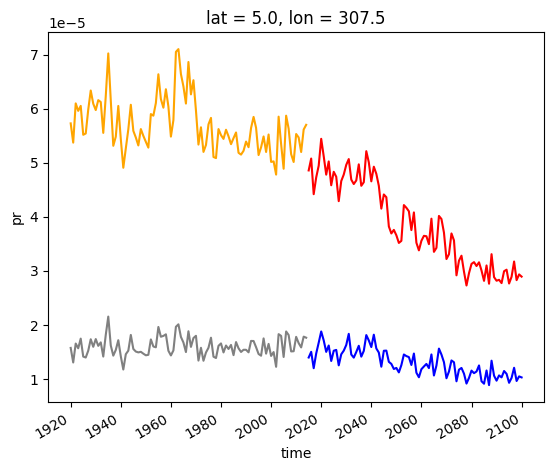

In [256]:
model = 'MPI-ESM1-2-LR'

tropics_pr.hist_dsets[model].resample(time='AS').mean().mean('member_id').plot(color='gray')
tropics_pr.future_dsets[model].resample(time='AS').mean().mean('member_id').plot(color='blue')

tropics_pr_qdm.hist_dsets[model].resample(time='AS').mean().mean('member_id').plot(color='orange')
tropics_pr_qdm.future_dsets[model].resample(time='AS').mean().mean('member_id').plot(color='red')



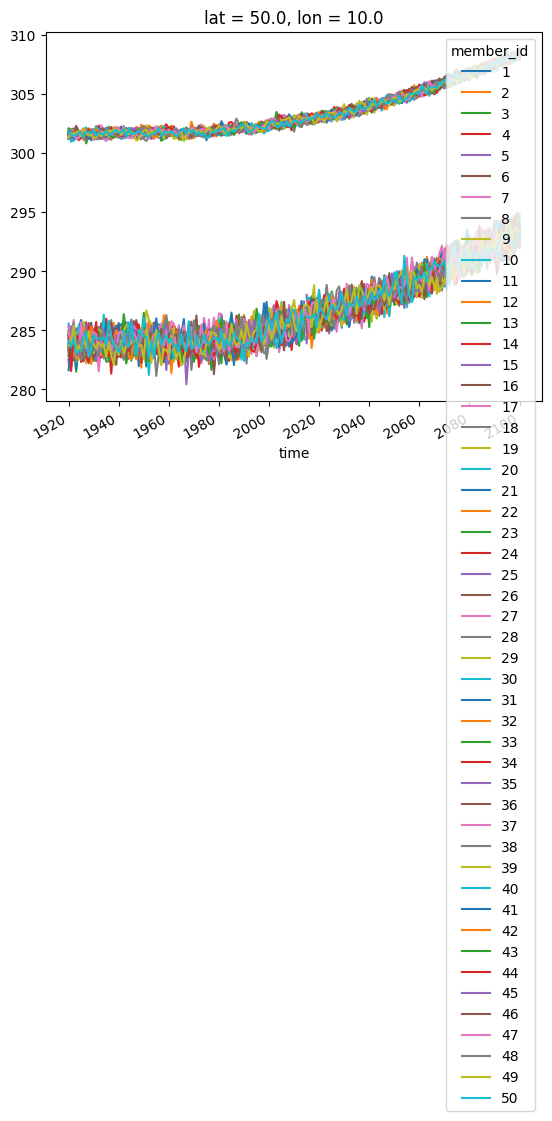

In [105]:
model = 'CanESM5'

tropics.hist_dsets[model].resample(time='AS').mean().plot(hue='member_id')
tropics.future_dsets[model].resample(time='AS').mean().plot(hue='member_id')

large_ens_hist[model].resample(time='AS').mean().plot(hue='member_id')
large_ens_future[model].resample(time='AS').mean().plot(hue='member_id')

#obs.resample(time='AS').mean().plot()

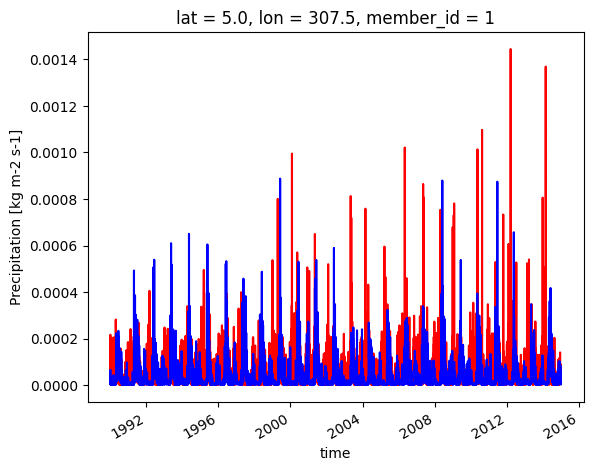

In [113]:
model = 'CanESM5'
year = slice('1990','2014')

reanalysis_daily[cmip2era[variable]].sel(time=year).plot(color='red')
tropics_pr.hist_dsets[model].sel(time=year, member_id=1).plot(color='blue')

In [67]:
reanalysis_daily

<xarray.Dataset>
Dimensions:  (time: 14975)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
    lat      float32 5.0
    lon      float32 -53.0
Data variables:
    t2m_max  (time) float32 25.65 29.95 30.88 28.3 ... 29.88 29.41 28.54 29.52

In [ ]:
obs =  reanalysis_daily[cmip2era[variable]]*(997/(1000*24*60*60))

model = 'MPI-ESM1-2-LR'

large_ens_future_1 = qdm_large_ensemble(
    tropics.future_dsets[model],
    tropics.hist_dsets[model],
    obs.load(),
    monthly_w = 3,
)

In [ ]:
large_ens_hist_1 = qdm_large_ensemble(
    tropics.hist_dsets[model],
    tropics.hist_dsets[model],
    obs.load(),
    monthly_w = 3,
)

In [ ]:
model = 'MPI-ESM1-2-LR'

tropics.hist_dsets[model].resample(time='AS').mean().mean('member_id').plot(color='gray')
tropics.future_dsets[model].resample(time='AS').mean().mean('member_id').plot(color='blue')

large_ens_hist_1.resample(time='AS').mean().mean('member_id').plot(color='orange')
large_ens_future_1.resample(time='AS').mean().mean('member_id').plot(color='red')

obs.resample(time='AS').mean().plot()

In [ ]:
tropics.hist_dsets[model].mean('member_id').values


In [ ]:
tropics.hist_dsets[model].sel(member_id=1)

In [ ]:
sns.kdeplot(tropics.hist_dsets[model].sel(member_id=1).values.flatten())


In [ ]:
sns.kdeplot(tropics.hist_dsets[model].values.flatten(), cumulative =True)
sns.kdeplot(large_ens_hist.values.flatten(), cumulative =True)
sns.kdeplot(obs_r, cumulative =True)

In [ ]:
sns.kdeplot(tropics.hist_dsets[model].values.flatten(), cumulative =True)

sns.kdeplot(tropics.future_dsets[model].values.flatten(), cumulative =True)
sns.kdeplot(large_ens_hist.values.flatten(), cumulative =True)
sns.kdeplot(large_ens_future.values.flatten(), cumulative =True)

sns.kdeplot(obs_r, cumulative =True)

In [ ]:
model = 'MIROC6'

tropics.hist_dsets[model].resample(time='AS').mean().mean('member_id').plot()
tropics.future_dsets[model].resample(time='AS').mean().mean('member_id').plot()

large_ens_hist.resample(time='AS').mean().mean('member_id').plot()
large_ens_future.resample(time='AS').mean().mean('member_id').plot()

obs_r.resample(time='AS').mean().plot()

In [ ]:
model = 'MIROC6'
large_ens_hist.resample(time='1M').mean().sel(member_id=1).plot()
large_ens_future.resample(time='1M').mean().sel(member_id=1).plot()

tropics.hist_dsets[model].resample(time='1M').mean().sel(member_id=1).plot()
tropics.future_dsets[model].resample(time='1M').mean().sel(member_id=1).plot()

obs_r.resample(time='1M').mean().plot()

In [ ]:
model = 'MIROC6'
large_ens_hist.rolling(time=365*10).mean().sel(member_id=1).plot()
large_ens_future.rolling(time=365*10).mean().sel(member_id=1).plot()

tropics.hist_dsets[model].rolling(time=365*10).mean().sel(member_id=1).plot()
tropics.future_dsets[model].rolling(time=365*10).mean().sel(member_id=1).plot()

obs_r.rolling(time=365*10).mean().plot()